In [54]:
import bisect
# import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
# from networkx.drawing.nx_pydot import graphviz_layout
import pydot

import dalmatian 

from helper import *
from gk_helper import *
from scipy.stats import iqr



# Specify inputs 

In [55]:
# Specify wbc and treatment files for growth kinetics 
patient = 'JB-0126'

wbc_file = 'data/JB_0126_wbc.txt'

# Load treatment file 
treatment = pd.read_csv("data/JB_0126_tx.txt", sep = '\t')


In [57]:
# Get input files from Terra through dalmatian
workspace ='broad-firecloud-ibmwatson/Brown_Getz_IBM_99-224_Exomes_Liang'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')
abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [ ]:
mcmc_df

# Helper functions to parse the input files 

In [58]:
def load_wbc_file(file):
    """
    Parse wbc file

    Args:
        wbc file

    Returns:
        variables as a list

    """

    df = pd.read_csv(file, sep='\t')

    # Get all time points
    times = df.dfd.tolist()

    # Get times that are in the interpolation range
    t = pd.notna(df['sample_id'])
    sample_time_index = [i for i, x in enumerate(t) if x]
    first_sample_index = sample_time_index[0]
    last_sample_index = sample_time_index[-1]
    df_interpolate = df.iloc[first_sample_index:last_sample_index + 1, :]
    times_interpolate = df_interpolate.dfd.tolist()
    wbc_interpolate = df_interpolate.wbc.tolist()

    # Get all wbc points
    wbc = df.wbc.tolist()

    # Get the sample list
    sample_list = df.sample_id[pd.notna(df.sample_id)].tolist()

    # Get the times at sample points
    times_sample = df.dfd[pd.notna(df.sample_id)].tolist()

    # Get the wbc at sample points
    wbc_sample = df.wbc[pd.notna(df.sample_id)].tolist()

    # Get the times that are not at sample points
    times_others = sorted(list(set(times) - set(times_sample)))

    return times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others


In [59]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = load_wbc_file(wbc_file)

In [60]:
times_sample[9]

4918

In [61]:
treatment = treatment[1:]
treatment

,tx,tx_start,tx_end
1,Venetoclax,2236,2924.0
2,Ibrutinib,2930,4444.0
3,Sunsets,4540,4582.0
4,Ibrutinib,4800,4922.0
5,Pirto,4925,5163.0
6,Duv+Ven,5168,5380.0
7,RIC Haplo PBSCT,5387,NaN


In [62]:
def plot_ccf(df, ax, times_sample):
    # Keep the necessary columns 
    cols = ['Sample_ID','Cluster_ID','postDP_ccf_mean','postDP_ccf_CI_low','postDP_ccf_CI_high' ]
    df = df[cols]
    cluster_list = df.Cluster_ID.unique().tolist()
    number_samples = len(df.Sample_ID.unique())
    
    tick_list = ['T'+ str(i) for i in range(number_samples)] 
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    

    for i in cluster_list:
        x = df[df.Cluster_ID == i].Sample_ID
        y = df[df.Cluster_ID == i].postDP_ccf_mean
        ci_low = df[df.Cluster_ID == i].postDP_ccf_CI_low
        ci_high = df[df.Cluster_ID == i].postDP_ccf_CI_high
        
#         if x_scale == 'sample':
#             x_axis = np.arange(0,number_samples) 
        
#         else:
#             x_axis = times_sample
        ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o', label = i)
    
#         ax.plot(x_axis, y,c= ClusterColors.get_hex_string(i), marker ='o')
        ax.fill_between(x_axis, ci_low, ci_high, color= ClusterColors.get_hex_string(i), alpha = 0.1)
        
        
        
        ax.set_xlabel('Samples')
        ax.set_xticks(x_axis)

        ax.set_xticklabels(tick_list, fontsize =8)

        ax.set_ylabel('CCF')
        ax.legend()
        
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2

#         ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
        ax.axvspan(xmin = start, xmax= end,  facecolor= cmap(i), alpha = 0.2)

#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')

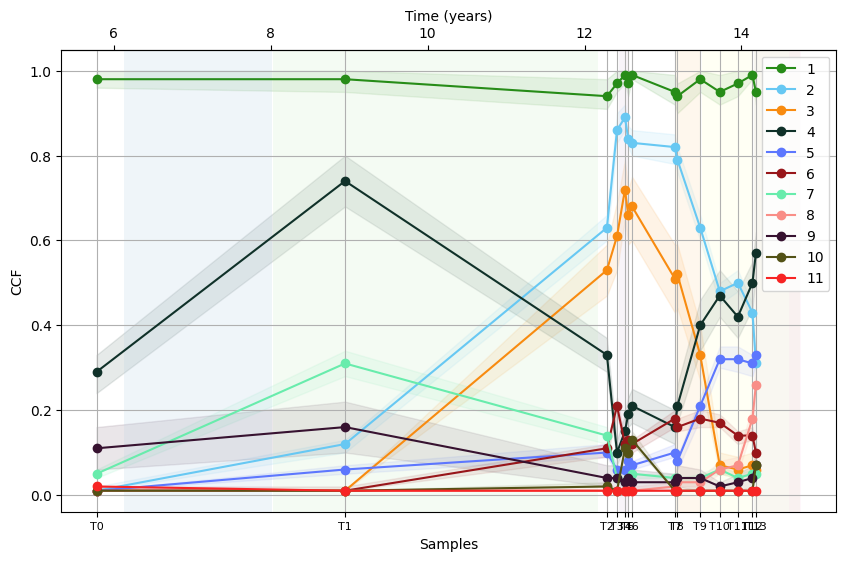

In [63]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_ccf(cluster_CCF_df,ax, times_sample )

In [64]:
def interpolate_abundance(abundance, mcmc, mode="interpolate_only"):
    """
    Parse abundance file and get abundance information and calculate interpolated abundance

    Args:
        cell_population_abundance file and mcmc_trace file
        mode: "interpolate_only" or "extrapolate"

    Returns:
        lists

    """

    cluster_map = {}

    # Get the cluster list from the mcmc file
    cluster_list = mcmc.Cluster_ID.unique().tolist()

    # Map the abundacne to each cluster in a dictionary
    for cluster_id in cluster_list:
        abundance['cluster'] = abundance['Cell_population'].str.split('_').str[-1].str[2:].astype(int)

        cluster_map[cluster_id] = abundance[abundance.cluster == cluster_id]

    ## To get abundance information from the cell_population_abundances.tsv
    cluster_abundance = {}
    for cluster_id, abundances in cluster_map.items():
        cluster_abundances = []
        ## iterate through the samples in the wbc file to make sure the order is correct
        for sample_name in sample_list:
            sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)
            cluster_abundances.append(sample_abundances / 100)
        cluster_abundance[cluster_id] = cluster_abundances

    ## To calculate interpolated abundance
    inter_abundance = {}
    for cluster_id, abundance in cluster_abundance.items():
        abundance_first = abundance[0]
        abundance_last = abundance[-1]
        if mode == "extrapolate":
            interpolate_func = interpolate.interp1d(times_sample, abundance, bounds_error=False,
                                                    fill_value=(abundance_first, abundance_last))
            abundance_interpolate = interpolate_func(times)

        if mode == "interpolate_only":
            interpolate_func = interpolate.interp1d(times_sample, abundance)

            abundance_interpolate = interpolate_func(times_interpolate)

        inter_abundance[cluster_id] = list(abundance_interpolate)

    return cluster_list, cluster_abundance, inter_abundance

In [65]:
cluster_list, cluster_abundance, inter_abundance = interpolate_abundance(abundance_df, mcmc_df)

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_80732/47543564.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundances = float(abundances[abundances.Sample_ID == sample_name].Cell_abundance)


In [71]:
def calc_subclone(wbc, inter_abundance, cluster_list, mode = "default" , input_type = "default"):
    
    """
    Calculate subclone abundance from interpolated abundance

    Args:
        wbc and inter_abundance
        mode: "default" or "positive (ensure positivity after taking the log)"
        input type: "default" or "mcmc (contains values of all iterations)"
    Returns:
        dictionaries

    """
    
    subclone_population = {}
    log_subclone ={}
    log_subclone_raw ={}
    
    if input_type == "default":
        for cluster_id in cluster_list:
            subclone_population[cluster_id] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id])]
            if mode == "default":
                log_subclone[cluster_id] = [np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [np.log(item*1000) for item in subclone_population[cluster_id]] 

            if mode == "positive":
                log_subclone[cluster_id] = [0 if item <1 else np.log(item) for item in subclone_population[cluster_id]]

                log_subclone_raw[cluster_id] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population[cluster_id]]

    if input_type == "mcmc":
        for cluster_id in cluster_list:
         
            subclone_population_per_iter = {}
            log_subclone_per_iter = {}
            log_subclone_raw_per_iter = {}
            
            for iter_idx in range(250):
                
                subclone_population_per_iter[iter_idx] = [_wbc*(abundance+1e-4) for _wbc, abundance in zip(wbc, inter_abundance[cluster_id][iter_idx])]
                if mode == "default":
                    log_subclone_per_iter[iter_idx] = [np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [np.log(item*1000) for item in subclone_population_per_iter[iter_idx]] 

                if mode == "positive":
                    log_subclone_per_iter[iter_idx] = [0 if item <1 else np.log(item) for item in subclone_population_per_iter[iter_idx]]

                    log_subclone_raw_per_iter[iter_idx] = [ 0 if item <1 else np.log(item*1000) for item in subclone_population_per_iter[iter_idx]]

            subclone_population[cluster_id] = subclone_population_per_iter
            log_subclone[cluster_id] = log_subclone_per_iter
            log_subclone_raw[cluster_id] = log_subclone_raw_per_iter
                
    return subclone_population, log_subclone, log_subclone_raw

In [72]:
# calculate only at sample points
subclone_sample, log_subclone_sample, log_subclone_raw_sample = calc_subclone(wbc_sample, cluster_abundance, cluster_list, mode = "default")

In [73]:
def get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample):
    
    """
    Get cell abundance and interpolated cell abundance from all mcmc iterations

    Args:
        cluster_list, mcmc_df, sample_list
    Returns:
        a dictionary with key: cluster and value: 250 iterations of cell abundance

    """
    all_abundance = {}
    interpolated_all_abundance = {}
    for cluster in cluster_list:

        abundance_per_iter ={}
        inter_abundance_per_iter = {}
        for iter_idx in range(250):

            df_mcmc_iter_clust = mcmc_df[(mcmc_df.Iteration == iter_idx) & (mcmc_df.Cluster_ID == cluster) ]

            cluster_abundances = []
            ## iterate through the samples in the wbc file to make sure the order is correct
            for sample_name in sample_list:
                sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)
                cluster_abundances.append(sample_abundance / 100)

            abundance_per_iter[iter_idx] = cluster_abundances
            
            
        all_abundance[cluster] = abundance_per_iter
        
    return all_abundance

In [74]:
all_abundance = get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_80732/2664756645.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sample_abundance = float(df_mcmc_iter_clust[df_mcmc_iter_clust.Sample_ID == sample_name].Abundance)


In [75]:
subclone_sample_mcmc, log_subclone_sample_mcmc, log_subclone_raw_sample_mcmc = calc_subclone(wbc_sample, all_abundance, cluster_list, mode = "default", input_type = "mcmc")

In [76]:
def slice_wbc(dfd_first, dfd_last, times, wbc, times_sample):
    '''
    select wbc between the two dfds 

    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd_last and time_ >=dfd_first]

    smallest_times_selected = min(times_selected)
    largest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)
    largest_index = times.index(largest_times_selected)

    wbc_selected = wbc[smallest_index: largest_index+ 1]

    return times_selected, wbc_selected

In [77]:
# Select the time period where exponential pattern is assumed 

# Pirto 
exp_sample_start = 10
exp_sample_end = 12


In [78]:
times_sliced, wbc_sliced = slice_wbc(times_sample[exp_sample_start], times_sample[exp_sample_end], times, wbc, times_sample)

1 [  1.05387228 -14.38806918]
2 [-1.12878795 17.9184784 ]
3 [-1.12738622 16.62376576]
4 [ 0.59039324 -7.78116862]
5 [-3.62723814 52.44176131]
6 [-2.52077226 36.79558728]
7 [-1.47733041 21.21963485]
8 [  0.8936604  -11.20782891]
9 [-0.23320739  3.49126201]
10 [-1.40939516 18.62410155]


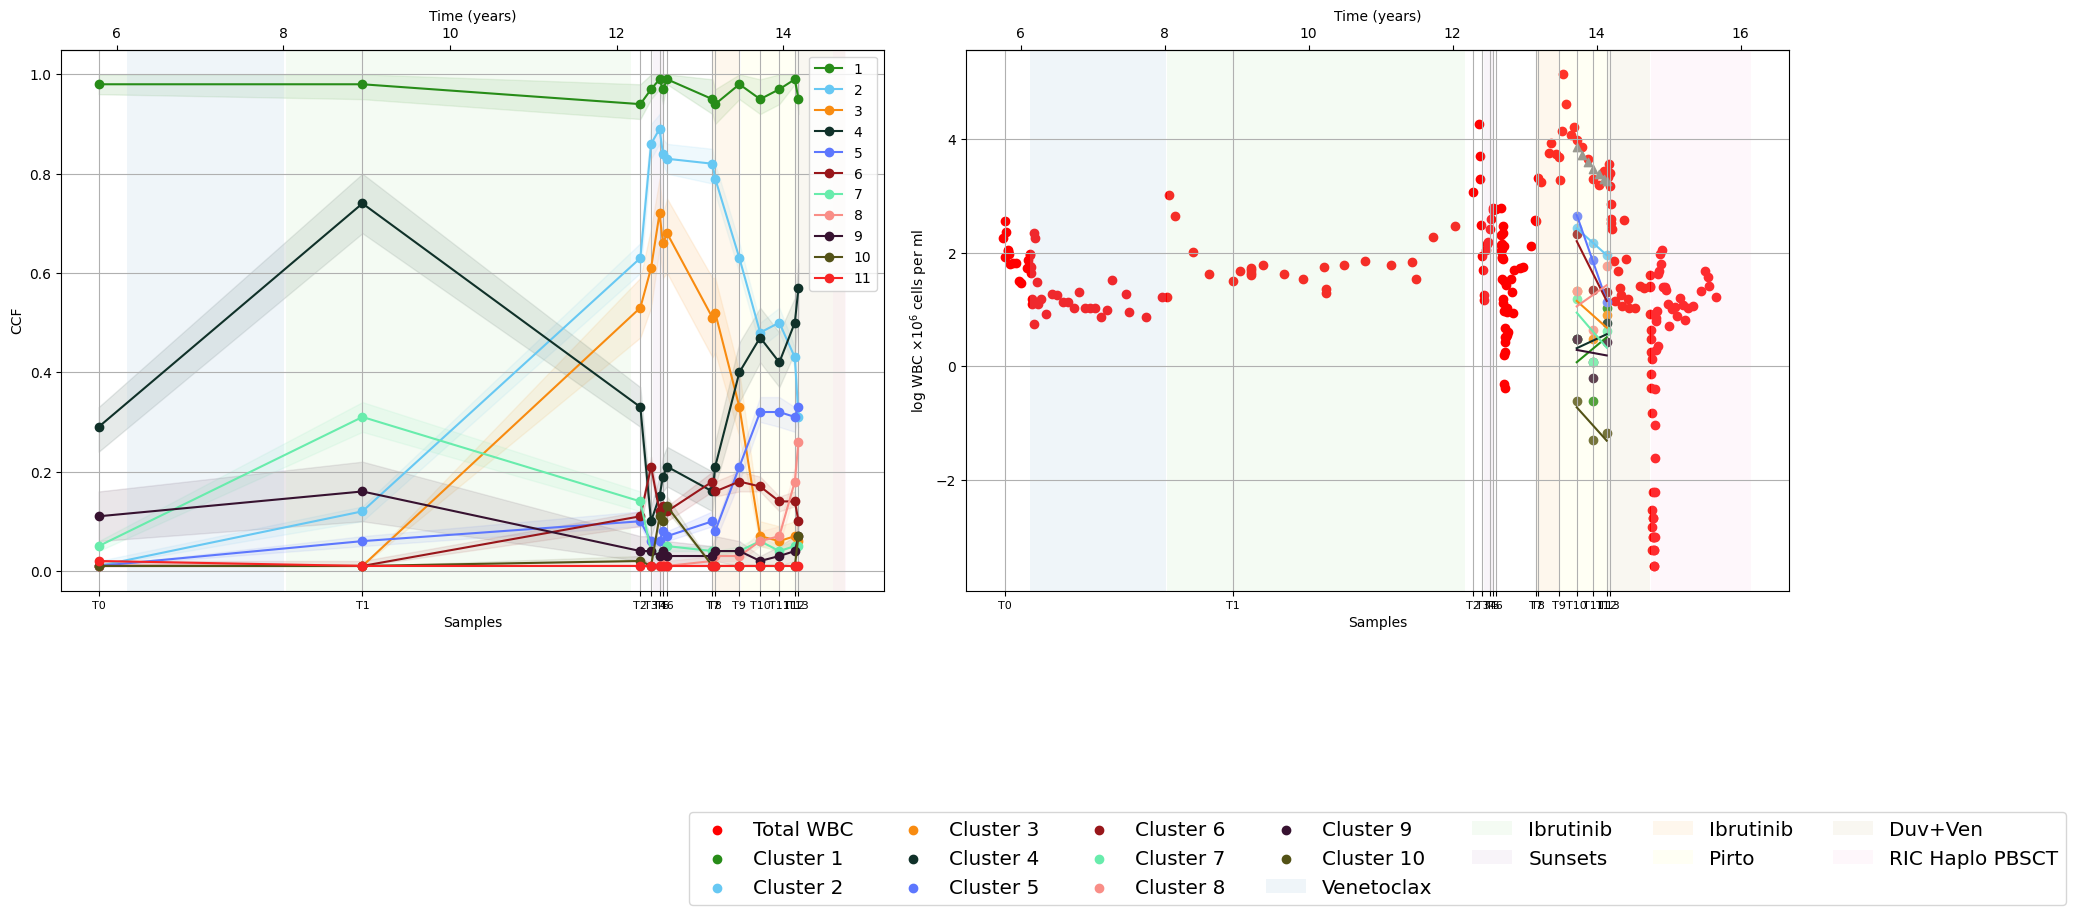

In [26]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')



    cluster_cell_population = {}
    for i in clusters:
        
        
        
         # Interpolate during treatment 

        exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
        exp_year = [ i/365 for i in np.array(exp_times)]
        exp_subclone = log_subclone_sample[i][exp_sample_start : exp_sample_end + 1 ]

        
        ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
        model = np.polyfit(exp_year, exp_subclone, 1)
        print(i, model)

        predict_x = times_sliced
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

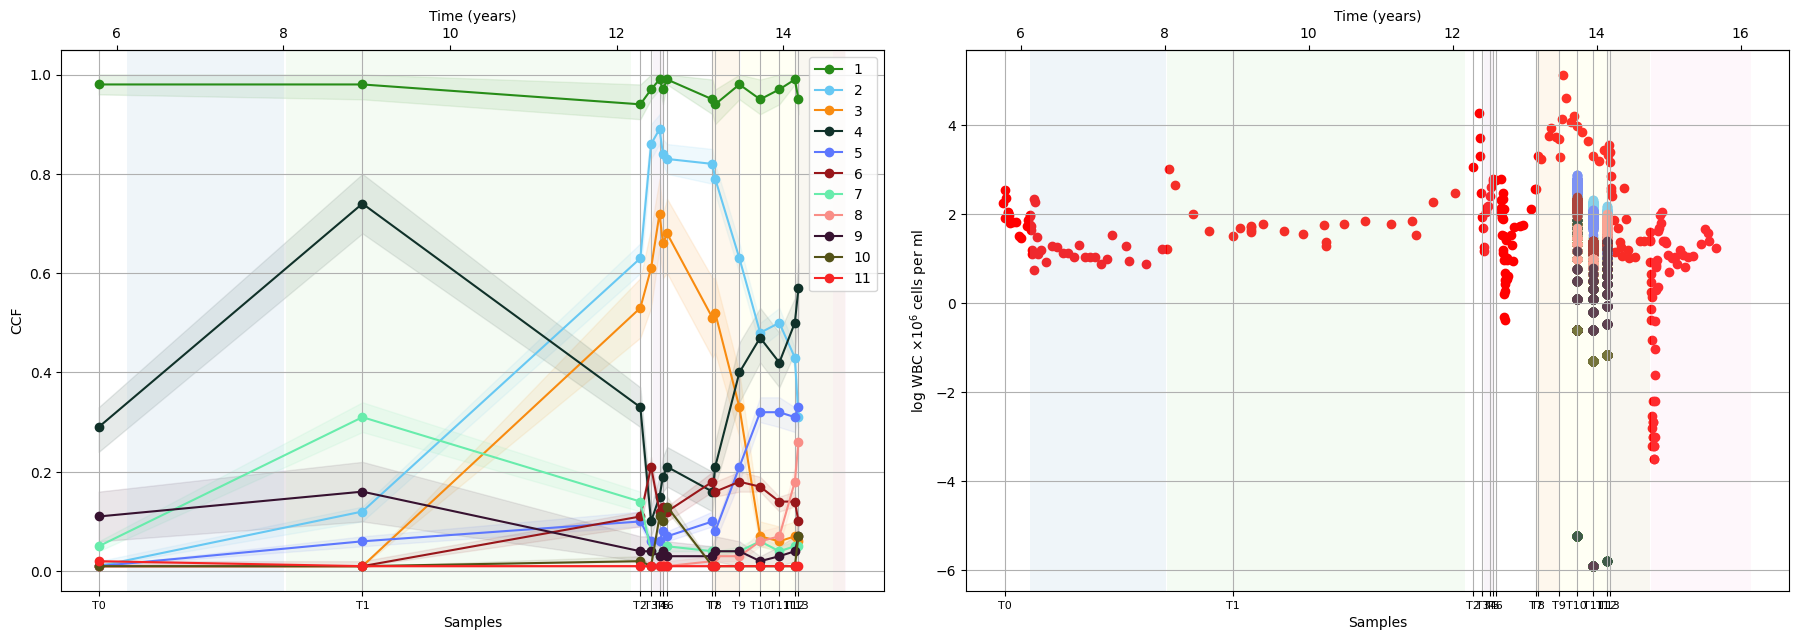

In [27]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
L528W_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in range(250):
        
         # Interpolate during treatment 

            exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
            exp_year = [ i/365 for i in np.array(exp_times)]
            exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


            ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

            model = np.polyfit(exp_year, exp_subclone, 1)
            
            if i ==8:
                
                L528W_rate_mcmc.append(model[0])
    
      

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])
# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [32]:
def mean_confidence_interval(rate_mcmc):
    
    lower_ci = np.percentile(rate_mcmc, 2.5, axis=0)
    upper_ci = np.percentile(rate_mcmc, 97.5, axis=0)
    mean = np.mean(rate_mcmc)
    return lower_ci, mean, upper_ci
    print(lower_ci, mean, upper_ci)

In [35]:
lower_ci, mean, upper_ci = mean_confidence_interval(L528W_rate_mcmc)

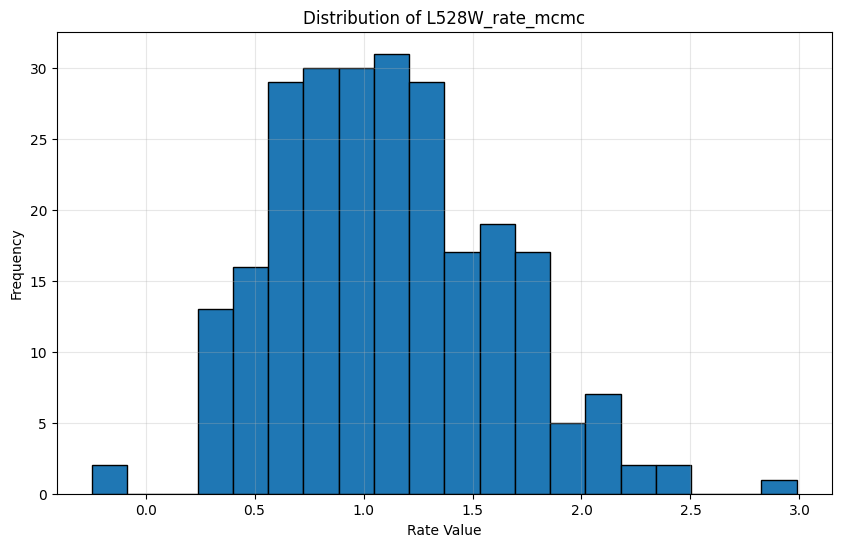

95% Confidence Interval: 1.11 (0.31, 2.16)


In [37]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(L528W_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of L528W_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")

In [34]:
# C481S decline during Pirto 


In [49]:
filtered_indices = [key for key, value in all_abundance[5].items() if not any(v == 0 for v in value[10:13])]
expected_set = list(set(range(250)))
filtered_indices ==expected_set

True

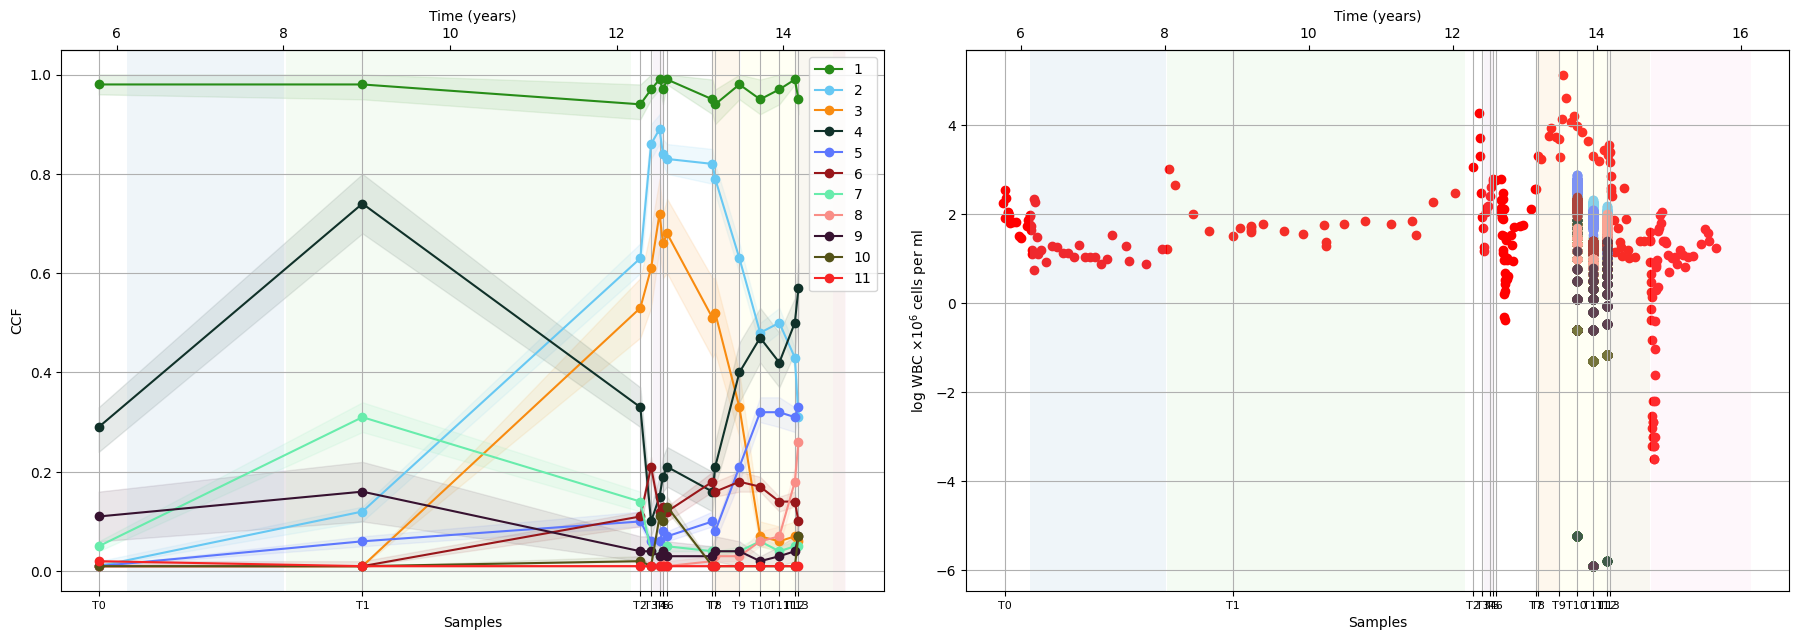

In [38]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
C481S_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in range(250):
        
         # Interpolate during treatment 

            exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
            exp_year = [ i/365 for i in np.array(exp_times)]
            exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


            ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

            model = np.polyfit(exp_year, exp_subclone, 1)
            
            if i ==5:
                
                C481S_rate_mcmc.append(model[0])
    
      

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])

# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [41]:
lower_ci, mean, upper_ci =mean_confidence_interval(C481S_rate_mcmc)

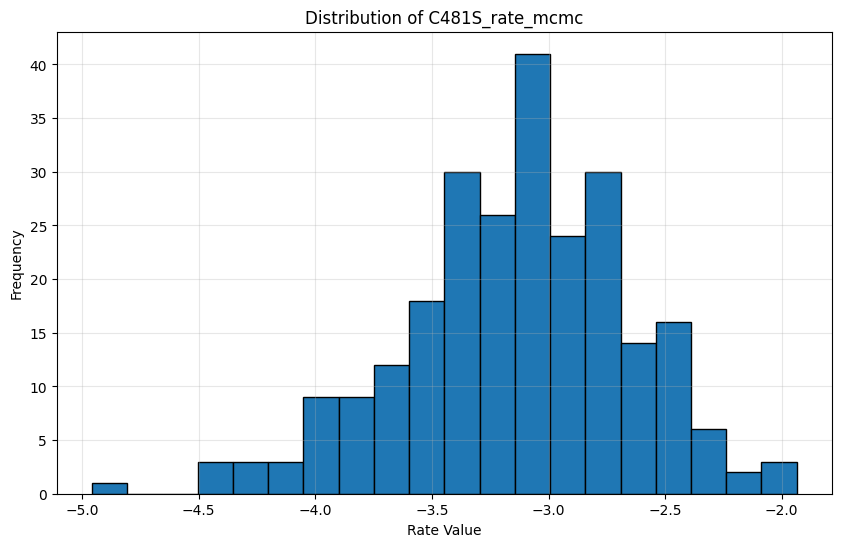

95% Confidence Interval: -3.14 (-4.21, -2.35)


In [42]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(C481S_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of C481S_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")

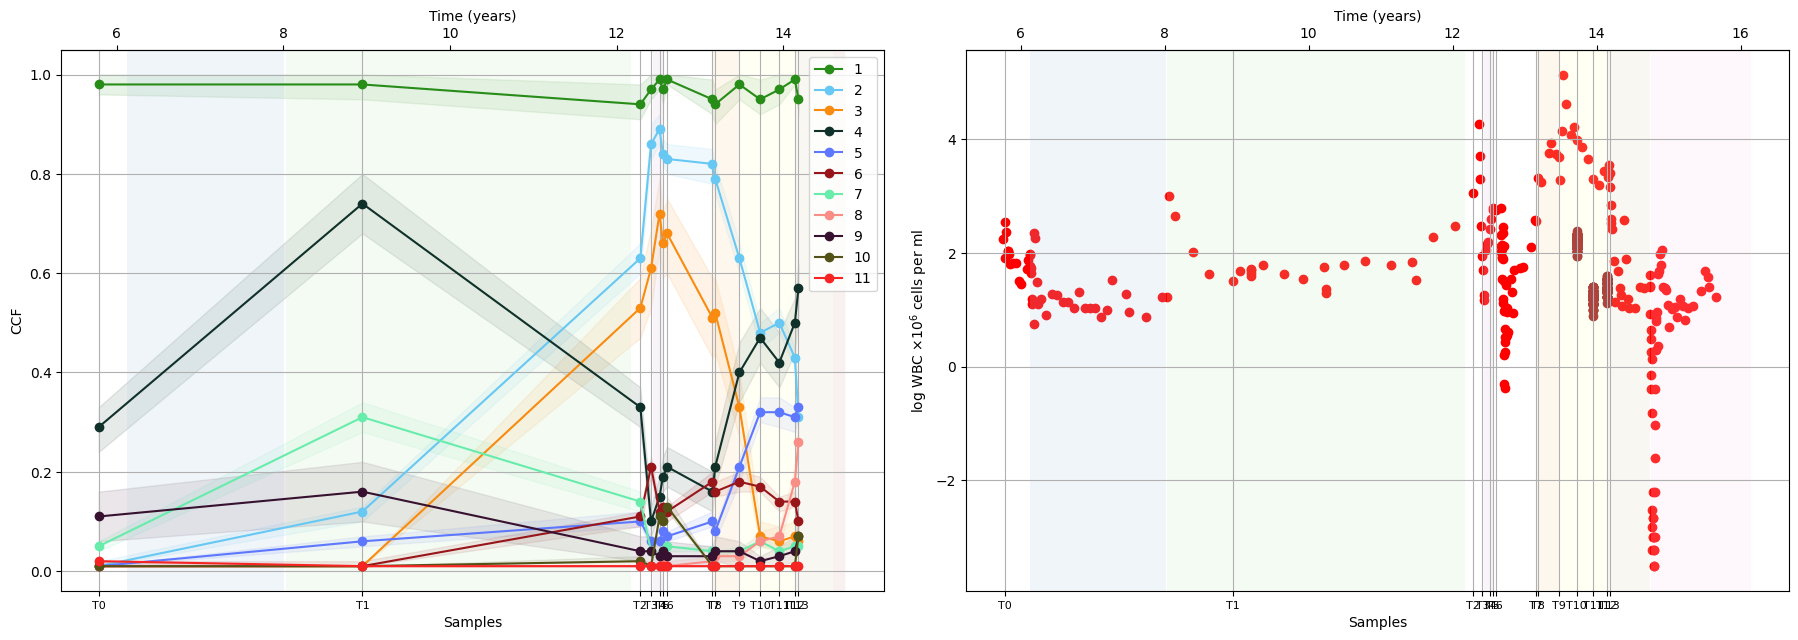

In [79]:
# Get C481R in Pirto
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
C481R_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in range(250):
            if i ==6:
         # Interpolate during treatment 

                exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
                exp_year = [ i/365 for i in np.array(exp_times)]
                exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


                ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

                model = np.polyfit(exp_year, exp_subclone, 1)
            
            
                C481R_rate_mcmc.append(model[0])
    
      

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])

lower_ci, mean, upper_ci = mean_confidence_interval(C481R_rate_mcmc)

# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

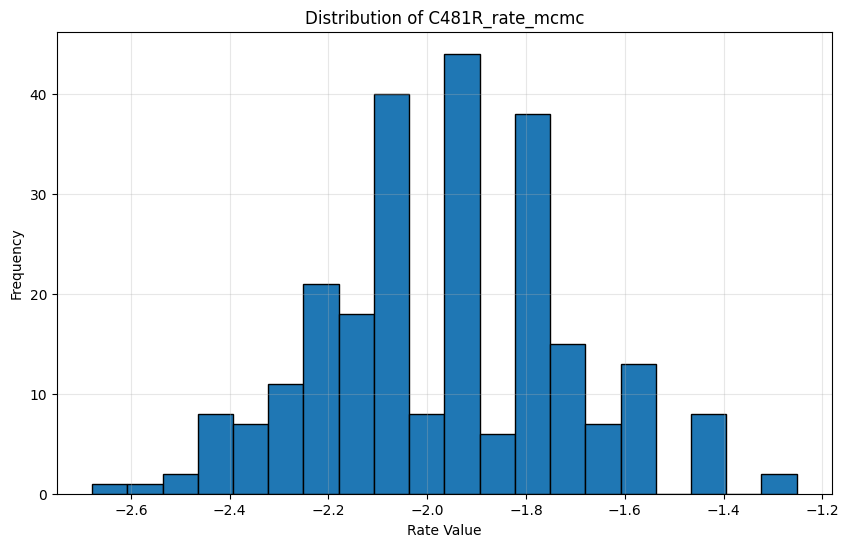

95% Confidence Interval: -1.96 (-2.41, -1.46)


In [80]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(C481R_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of C481R_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")

1 [-1.72426967 15.03184006]
2 [-1.60286311 13.54036869]
3 [  1.61191282 -17.51890436]
4 [ 0.24531375 -2.25560264]
5 [ 0.71009173 -8.07061781]
6 [  2.5063117  -30.13705709]
7 [ 0.25988489 -2.09842132]
8 [ 0.46749444 -7.27871147]
9 [ 0.00665009 -0.52528045]
10 [ 0.67372376 -9.12404006]


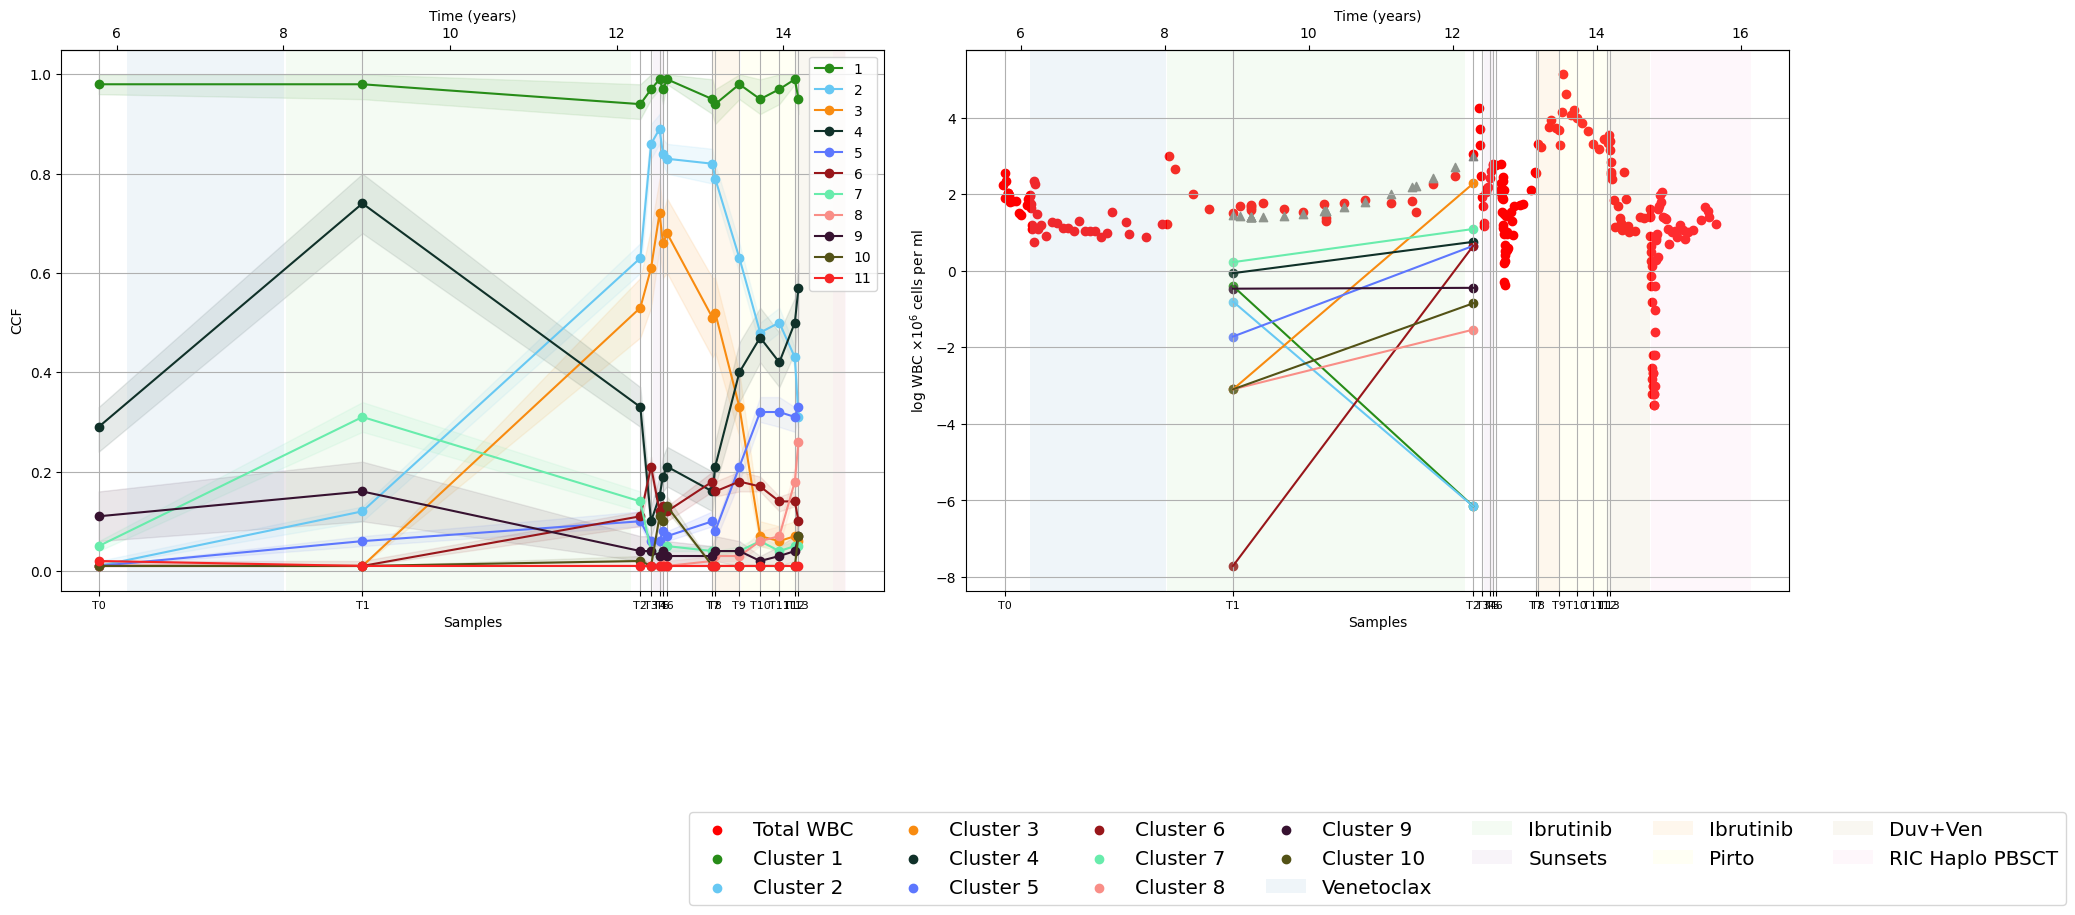

In [81]:
# Get C481S in Ibr

exp_sample_start = 1
exp_sample_end = 2

times_sliced, wbc_sliced = slice_wbc(times_sample[exp_sample_start], times_sample[exp_sample_end], times, wbc, times_sample)
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')



    cluster_cell_population = {}
    for i in clusters:
        
        
        
         # Interpolate during treatment 

        exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
        exp_year = [ i/365 for i in np.array(exp_times)]
        exp_subclone = log_subclone_sample[i][exp_sample_start : exp_sample_end + 1 ]

        
        ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)
        
        model = np.polyfit(exp_year, exp_subclone, 1)
        print(i, model)

        predict_x = times_sliced
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

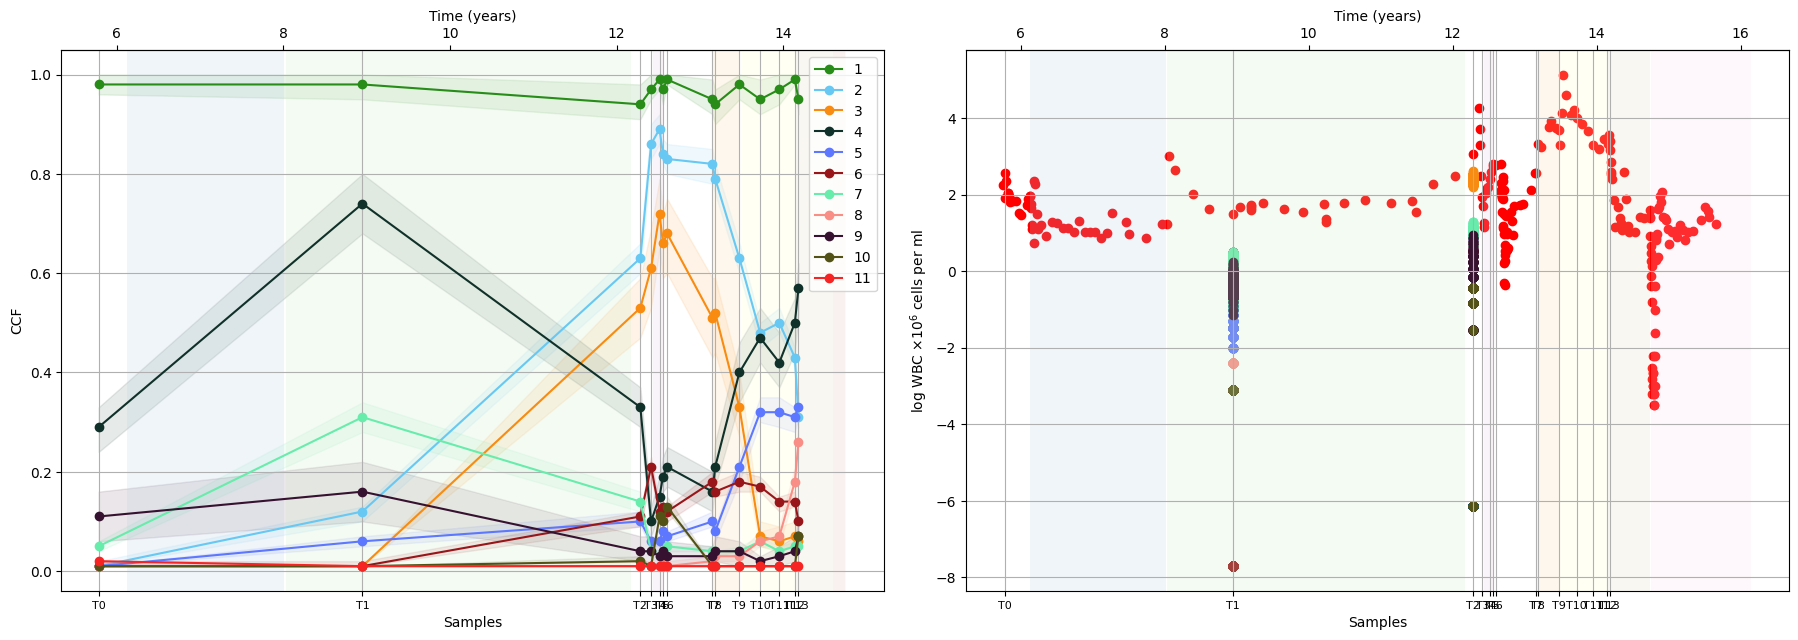

In [84]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]
C481S_rate_mcmc = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times)]
    ax.scatter(x_year_selected,np.log(wbc), label = 'Total WBC', c = 'red')


    
    cluster_cell_population = {}
    for i in clusters:
        
        for iter_idx in range(250):
        
         # Interpolate during treatment 

            exp_times = times_sample[exp_sample_start : exp_sample_end + 1 ]
            exp_year = [ i/365 for i in np.array(exp_times)]
            exp_subclone = log_subclone_sample_mcmc[i][iter_idx][exp_sample_start : exp_sample_end + 1 ]


            ax.scatter(exp_year,exp_subclone, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)

            model = np.polyfit(exp_year, exp_subclone, 1)
            
            if i ==5:
                
                C481S_rate_mcmc.append(model[0])
    
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


plot_ccf(cluster_CCF_df,ax1, times_sample )

plot_sub(ax2, [1,2,3,4,5,6,7,8,9,10])
# ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


lower_ci, mean, upper_ci =mean_confidence_interval(C481S_rate_mcmc)

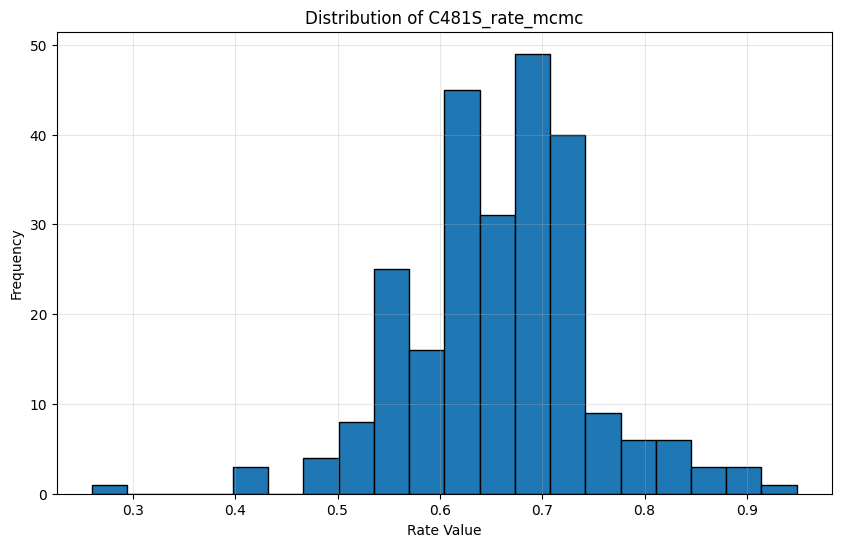

95% Confidence Interval: 0.65 (0.47, 0.85)


In [85]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(C481S_rate_mcmc, bins=20, edgecolor='black')
plt.title('Distribution of C481S_rate_mcmc')
plt.xlabel('Rate Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print(f"95% Confidence Interval: {mean:.2f} ({lower_ci:.2f}, {upper_ci:.2f})")